# GALEX data

Read test data and determine the schema of GALEX data


## Basic Packages

In [1]:
import numpy as np
import pandas as pd
import glob
import sys
import h5py
#from netCDF4 import Dataset
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

import pyarrow as pa
import pyarrow.parquet as pq

from functools import reduce
import operator
import gc

# Increase display width to 200 characters
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth', 200)

In [2]:
import os

from astropy.table import Table
from matplotlib.ticker import MultipleLocator

from astropy.utils.exceptions import AstropyWarning
import warnings
warnings.simplefilter('ignore', category=AstropyWarning)

In [3]:
# plot settings
#plt.rc('font', family='serif') 
#plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

## PySpark Session

In [4]:
%%time
# PySpark packages
from pyspark import SparkContext   
from pyspark.sql import SparkSession

import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark import Row
from pyspark.sql.window import Window as W


spark = SparkSession.builder \
    .master("yarn") \
    .appName("spark-shell") \
    .config("spark.driver.maxResultSize", "32g") \
    .config("spark.driver.memory", "32g") \
    .config("spark.executor.memory", "7g") \
    .config("spark.executor.cores", "1") \
    .config("spark.executor.instances", "100") \
    .config("spark.sql.hive.filesourcePartitionFileCacheSize", "2097152000") \
    .getOrCreate()



sc = spark.sparkContext
sc.setCheckpointDir("hdfs://spark00:54310/tmp/checkpoints")

spark.conf.set("spark.sql.debug.maxToStringFields", 500)
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

CPU times: user 4.97 ms, sys: 13.2 ms, total: 18.2 ms
Wall time: 36.2 s


## Explore the test data

### Looking around directories and files 

In [5]:
%pwd

'/home/shong/work/eda-catalogs/galex/notebook'

In [6]:
localdatadir = '/home/shong/work/eda-catalogs/galex/data/'

In [7]:
%ls {localdatadir}

GUVCat_AIS_FOV055_glat85_00N__90_00N.csv
GUVCat_AIS_FOV055_glat85_00N__90_00N.csv.gz


### Extracting Schema 

- I tried to extract schema as usual by writing my own code, but ChatGPT made the below though I even did not request this. I only asked about giving me some clues to extract the schema from the sample csv. 
- A.I. evolves even faster than my thoughts. 

In [8]:
galex_schema = T.StructType([
    T.StructField("objid", T.LongType(), True),
    T.StructField("photoextractid", T.LongType(), True),
    T.StructField("mpstype", T.StringType(), True),
    T.StructField("avaspra", T.DoubleType(), True),
    T.StructField("avaspdec", T.DoubleType(), True),
    T.StructField("fexptime", T.DoubleType(), True),
    T.StructField("nexptime", T.DoubleType(), True),
    T.StructField("ra", T.DoubleType(), True),
    T.StructField("dec", T.DoubleType(), True),
    T.StructField("glon", T.DoubleType(), True),
    T.StructField("glat", T.DoubleType(), True),
    T.StructField("tilenum", T.IntegerType(), True),
    T.StructField("img", T.IntegerType(), True),
    T.StructField("subvisit", T.IntegerType(), True),
    T.StructField("fov_radius", T.DoubleType(), True),
    T.StructField("type", T.IntegerType(), True),
    T.StructField("band", T.IntegerType(), True),
    T.StructField("e_bv", T.DoubleType(), True),
    T.StructField("istherespectrum", T.IntegerType(), True),
    T.StructField("chkobj_type", T.IntegerType(), True),
    T.StructField("fuv_mag", T.DoubleType(), True),
    T.StructField("fuv_magerr", T.DoubleType(), True),
    T.StructField("nuv_mag", T.DoubleType(), True),
    T.StructField("nuv_magerr", T.DoubleType(), True),
    T.StructField("fuv_mag_auto", T.DoubleType(), True),
    T.StructField("fuv_magerr_auto", T.DoubleType(), True),
    T.StructField("nuv_mag_auto", T.DoubleType(), True),
    T.StructField("nuv_magerr_auto", T.DoubleType(), True),
    T.StructField("fuv_mag_aper_4", T.DoubleType(), True),
    T.StructField("fuv_magerr_aper_4", T.DoubleType(), True),
    T.StructField("nuv_mag_aper_4", T.DoubleType(), True),
    T.StructField("nuv_magerr_aper_4", T.DoubleType(), True),
    T.StructField("fuv_mag_aper_6", T.DoubleType(), True),
    T.StructField("fuv_magerr_aper_6", T.DoubleType(), True),
    T.StructField("nuv_mag_aper_6", T.DoubleType(), True),
    T.StructField("nuv_magerr_aper_6", T.DoubleType(), True),
    T.StructField("fuv_artifact", T.IntegerType(), True),
    T.StructField("nuv_artifact", T.IntegerType(), True),
    T.StructField("fuv_flags", T.IntegerType(), True),
    T.StructField("nuv_flags", T.IntegerType(), True),
    T.StructField("fuv_flux", T.DoubleType(), True),
    T.StructField("fuv_fluxerr", T.DoubleType(), True),
    T.StructField("nuv_flux", T.DoubleType(), True),
    T.StructField("nuv_fluxerr", T.DoubleType(), True),
    T.StructField("fuv_x_image", T.DoubleType(), True),
    T.StructField("fuv_y_image", T.DoubleType(), True),
    T.StructField("nuv_x_image", T.DoubleType(), True),
    T.StructField("nuv_y_image", T.DoubleType(), True),
    T.StructField("fuv_fwhm_image", T.DoubleType(), True),
    T.StructField("nuv_fwhm_image", T.DoubleType(), True),
    T.StructField("fuv_fwhm_world", T.DoubleType(), True),
    T.StructField("nuv_fwhm_world", T.DoubleType(), True),
    T.StructField("nuv_class_star", T.DoubleType(), True),
    T.StructField("fuv_class_star", T.DoubleType(), True),
    T.StructField("nuv_ellipticity", T.DoubleType(), True),
    T.StructField("fuv_ellipticity", T.DoubleType(), True),
    T.StructField("nuv_theta_j2000", T.DoubleType(), True),
    T.StructField("nuv_errtheta_j2000", T.DoubleType(), True),
    T.StructField("fuv_theta_j2000", T.DoubleType(), True),
    T.StructField("fuv_errtheta_j2000", T.DoubleType(), True),
    T.StructField("fuv_ncat_fwhm_image", T.DoubleType(), True),
    T.StructField("fuv_ncat_flux_radius_3", T.DoubleType(), True),
    T.StructField("nuv_kron_radius", T.DoubleType(), True),
    T.StructField("nuv_a_world", T.DoubleType(), True),
    T.StructField("nuv_b_world", T.DoubleType(), True),
    T.StructField("fuv_kron_radius", T.DoubleType(), True),
    T.StructField("fuv_a_world", T.DoubleType(), True),
    T.StructField("fuv_b_world", T.DoubleType(), True),
    T.StructField("nuv_weight", T.DoubleType(), True),
    T.StructField("fuv_weight", T.DoubleType(), True),
    T.StructField("prob", T.DoubleType(), True),
    T.StructField("sep", T.DoubleType(), True),
    T.StructField("nuv_poserr", T.DoubleType(), True),
    T.StructField("fuv_poserr", T.DoubleType(), True),
    T.StructField("ib_poserr", T.DoubleType(), True),
    T.StructField("nuv_pperr", T.DoubleType(), True),
    T.StructField("fuv_pperr", T.DoubleType(), True),
    T.StructField("CorV", T.StringType(), True),
    T.StructField("gRank", T.IntegerType(), True),
    T.StructField("ngrank", T.IntegerType(), True),
    T.StructField("primgid", T.LongType(), True),
    T.StructField("groupgid", T.LongType(), True),
    T.StructField("grankdist", T.IntegerType(), True),
    T.StructField("ngrankdist", T.IntegerType(), True),
    T.StructField("primgiddist", T.LongType(), True),
    T.StructField("groupgiddist", T.LongType(), True),
    T.StructField("groupgidtot", T.LongType(), True),
    T.StructField("difffuv", T.DoubleType(), True),
    T.StructField("diffnuv", T.DoubleType(), True),
    T.StructField("difffuvdist", T.DoubleType(), True),
    T.StructField("diffnuvdist", T.DoubleType(), True),
    T.StructField("sepas", T.DoubleType(), True),
    T.StructField("sepasdist", T.DoubleType(), True),
    T.StructField("inlargeobj", T.DoubleType(), True),
    T.StructField("largeobjsize", T.DoubleType(), True)
])


### Read the csv.gz 

In [9]:
localheader = 'file://'
hdfsheader = 'hdfs://spark00:54310'

In [10]:
hdfsdatapath = '/common/data/external-catalogs/raw/galex/original/'

In [11]:
#!hadoop fs -ls {hdfsheader+hdfsdatapath}

In [12]:
templist = !hadoop fs -ls {hdfsheader+hdfsdatapath}

In [13]:
templist[1].split(' ')[-1]

'hdfs://spark00:54310/common/data/external-catalogs/raw/galex/original/GUVCat_AIS_FOV055_glat00_00N__05_00N.csv.gz'

In [14]:
templist[-1]

'-rw-r--r--   3 shong supergroup   50143405 2024-07-01 09:39 hdfs://spark00:54310/common/data/external-catalogs/raw/galex/original/GUVCat_AIS_FOV055_glat90_00S__85_00S.csv.gz'

In [15]:
rawdf = \
    spark.read.schema(galex_schema) \
    .option("header",True) \
    .option("sep",",") \
    .csv(hdfsheader+hdfsdatapath)

In [16]:
%%time
rawdf.limit(4).toPandas().T

CPU times: user 9.19 ms, sys: 5.58 ms, total: 14.8 ms
Wall time: 3.43 s


,0,1,2,3
objid,6374645359059141628,6374645359059141636,6374645359059141662,6374645359059141721
photoextractid,6374645359058092032,6374645359058092032,6374645359058092032,6374645359058092032
mpstype,AIS,AIS,AIS,AIS
avaspra,179.434607,179.434607,179.434607,179.434607
avaspdec,37.495299,37.495299,37.495299,37.495299
fexptime,108.0,108.0,108.0,108.0
nexptime,108.0,108.0,108.0,108.0
ra,179.917638,179.893366,179.75436,179.936961
dec,37.224954,37.230385,37.23979,37.267931
glon,166.95279,166.98375,167.22462,166.78514


In [17]:
%%time
rawdf.select(['ra','dec','glon','glat']).describe().toPandas().T

CPU times: user 10.4 ms, sys: 3.06 ms, total: 13.4 ms
Wall time: 1min 45s


,0,1,2,3,4
summary,count,mean,stddev,min,max
ra,82992062,183.72899071500333,107.38481442439858,6.130351274548065E-6,359.9999992861237
dec,82992062,-0.2358758365596442,38.22273819590249,-89.48242467353317,89.52245499335916
glon,82992062,177.13619702742727,106.26192959503443,1.9349859E-6,360.0
glat,82992062,-0.7588886907013211,45.159986322949095,-89.993248,89.645363


- Total: 82,992,062
- ra,dec,glon,glat look good.

## Visualize GALEX using HealPix

#### HealPix settings

In [18]:
import healpy as hp
NSIDE = 512
NPIX = hp.nside2npix(NSIDE)
print(NPIX)

3145728


#### UDF for healpix indices

In [19]:
def getHealPixIndexLatLon(inlat, inlon, nside):
    lat_theta = 0.5*np.pi - np.radians(inlat)
    lon_phi = np.radians(inlon)    
    return int(hp.ang2pix(nside,theta = lat_theta,phi= lon_phi,nest=True))

In [20]:
from functools import partial
healpixudf = F.udf(partial(getHealPixIndexLatLon,nside=NSIDE),T.IntegerType())

In [21]:
rawdf = rawdf.withColumn('ipx512nested',healpixudf(F.col('glat'),F.col('glon')))

In [22]:
visdf = rawdf.select(['ra','dec','glon','glat','ipx512nested'])

In [23]:
visdf.cache()

DataFrame[ra: double, dec: double, glon: double, glat: double, ipx512nested: int]

#### Agg Count 

In [24]:
viscountdf = visdf.groupBy('ipx512nested').agg(F.count("*").alias("count"))

In [25]:
%%time
repdf = viscountdf.orderBy('ipx512nested').toPandas().set_index('ipx512nested')

CPU times: user 16.9 ms, sys: 25.8 ms, total: 42.8 ms
Wall time: 1min 11s


#### Filling the missing indices

In [26]:
full_index = pd.RangeIndex(start=0, stop=NPIX)
filledpdf = repdf.reindex(full_index, fill_value=0)

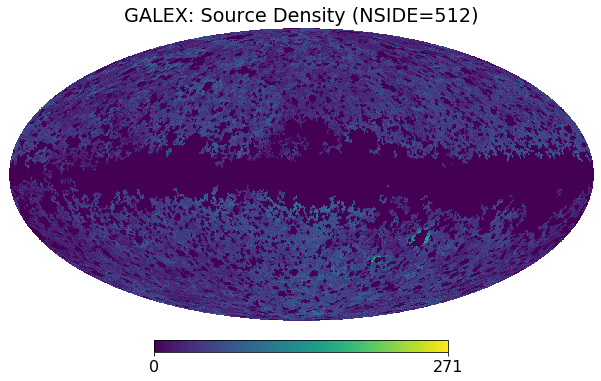

In [27]:
hp.mollview(filledpdf['count'].values,nest=True, \
            title='GALEX: Source Density (NSIDE=512)', \
            xsize=2000)

### Better Look 

In [28]:
from matplotlib import cm
from healpy.newvisufunc import projview, newprojplot

#### Celestial Equator

In [29]:
# the offset `l` is 50 degree. 
#why? figure this out by yourself as a homework of astro101 !!!
raeq = np.arange(0,359) + 50
deceq = np.zeros(359)

In [30]:
from astropy.coordinates import SkyCoord
import astropy.units as u
def getGalacticCoordinates(inra,indec):
    tmp_eclip = SkyCoord(inra * u.deg,indec * u.deg,frame='icrs')
    tmp_gal = tmp_eclip.transform_to('galactic')
    #print("lat_theta/pi= ",lat_theta/np.pi)
    #print("lon_phi/pi= ",lon_phi/np.pi)
    
    if float(tmp_gal.l.value) < 180.0:
        return [float(tmp_gal.l.value),float(tmp_gal.b.value)]
    else:
        return [(float(tmp_gal.l.value)-360.0),float(tmp_gal.b.value)]

In [31]:
tmpline = np.array(list(map(getGalacticCoordinates,raeq,deceq)))

In [32]:
eqline = tmpline.T

In [33]:
phieqline = eqline[0] * np.pi / 180.0 
thetaeqline = (90.0 - eqline[1])* np.pi /180.0

In [34]:
import warnings
warnings.filterwarnings("ignore")

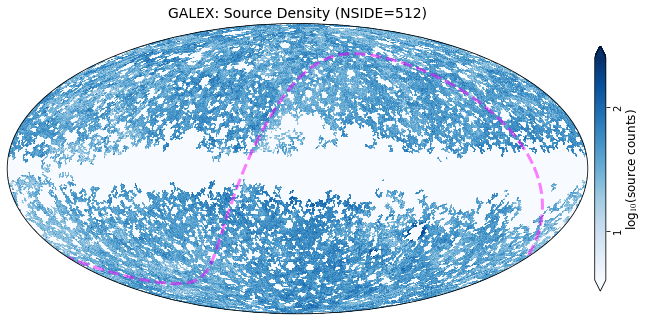

In [55]:
# classic healpy mollweide projections plot with graticule 
# and axis labels and vertical color bar

projview(
    np.nan_to_num(np.log10(filledpdf['count'].values),nan=0,neginf=0),
    coord=["G"],
    #graticule=True,
    #graticule_labels=True,
    unit=r'log$_{10}$(source counts)',
    #xlabel="longitude",
    #ylabel="latitude",
    min=0.6,
    max=2.4,
    cbar_ticks=[1,2,3],
    cb_orientation="vertical",
    projection_type="mollweide",
    cmap=cm.Blues,
    nest=True,
    override_plot_properties={"cbar_label_pad": 1.},
    title='GALEX: Source Density (NSIDE=512)'
)
newprojplot(thetaeqline,phieqline,linestyle='dashed', linewidth=3, \
            color='magenta', alpha=0.5)

plt.savefig('galex-galactic-nside512.pdf')
plt.show()